*Note*: This notebook is a slightly adapted version of a project task from Berkeley's Data 100 class authored by S. Lau, J. Gonzalez, D. Nolan and others.

# Case study part 2: Predicting Housing Prices in Cook County



<hr style="border: 1px solid #fdb515;" />
<hr style="border: 5px solid #003262;" />
<br/><br/>

## Introduction

In part 1 of the case study, you performed some basic Exploratory Data Analysis (EDA), laying out the thought process that leads to certain modeling decisions. Then, you added a few new features to the dataset and cleaned the data in the process.

In this second part, you will specify and fit a linear model to a few features of the housing data to predict house prices. Next, we will analyze the error of the model and brainstorm ways to improve the model's performance. Finally, we'll delve deeper into the implications of predictive modeling within the Cook County Assessor's Office (CCAO) case study, especially because statistical modeling is how the CCAO valuates properties. Given the history of racial discrimination in housing policy and property taxation in Cook County, consider the impacts of your modeling results as you work through this project, and think about what fairness might mean to property owners in Cook County.

After this part of the project, you should be comfortable with:
- Implementing a data processing pipeline using `pandas`.
- Using `statsmodels` to build and fit linear models.

In [1]:
import numpy as np

import pandas as pd
from pandas.api.types import CategoricalDtype

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

import zipfile
import os

# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

In [2]:
with zipfile.ZipFile('cook_county_data_comp.zip') as item:
    item.extractall()

Let's load the training and validation test data.

This dataset is split into a training set and a validation set and a test set. In this project, you will train a model on the training and validation sets. In the cell below, we load the training and validation sets into the `DataFrame` `training_val_data`.

In [3]:
training_data = pd.read_csv("cook_county_training.csv", index_col='Unnamed: 0')
val_data = pd.read_csv("cook_county_val.csv", index_col='Unnamed: 0')
training_val_data = pd.concat([training_data, val_data])

As a good sanity check, we should at least verify that the shape of the data matches the description.

In [4]:
# 122875 observations and 62 features in training data
assert training_data.shape == (122875, 62)
# 40958 observations and 62 features in val data
assert val_data.shape == (40958, 62)
# 40959 observations and 61 features in test data
assert training_val_data.shape == (163833, 62)

Let's remind ourselves of the data available to us in the Cook County dataset. Remember, a more detailed description of each variable is included in `codebook.txt`, which is in the same directory as this notebook. 

In [5]:
training_val_data.columns.values

array(['PIN', 'Property Class', 'Neighborhood Code', 'Land Square Feet',
       'Town Code', 'Apartments', 'Wall Material', 'Roof Material',
       'Basement', 'Basement Finish', 'Central Heating', 'Other Heating',
       'Central Air', 'Fireplaces', 'Attic Type', 'Attic Finish',
       'Design Plan', 'Cathedral Ceiling', 'Construction Quality',
       'Site Desirability', 'Garage 1 Size', 'Garage 1 Material',
       'Garage 1 Attachment', 'Garage 1 Area', 'Garage 2 Size',
       'Garage 2 Material', 'Garage 2 Attachment', 'Garage 2 Area',
       'Porch', 'Other Improvements', 'Building Square Feet',
       'Repair Condition', 'Multi Code', 'Number of Commercial Units',
       'Estimate (Land)', 'Estimate (Building)', 'Deed No.', 'Sale Price',
       'Longitude', 'Latitude', 'Census Tract',
       'Multi Property Indicator', 'Modeling Group', 'Age', 'Use',
       "O'Hare Noise", 'Floodplain', 'Road Proximity', 'Sale Year',
       'Sale Quarter', 'Sale Half-Year', 'Sale Quarter of Year'

<br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Question 1: Human Context and Ethics

In this part of the project, we will explore the human context of our housing dataset. **You should read [the introductory newspaper article](https://apps.chicagotribune.com/news/watchdog/cook-county-property-tax-divide/assessments.html) before attempting this question.**

<br>

--- 

### Question 1a
"How much is a house worth?" Who might be interested in an answer to this question? **Please list at least three different parties (people or organizations) and state whether each one has an interest in seeing the housing price be low or high.**

*Solution*: Possible parties include:
- The Assessor's office of a county fixing the tax each property owner has to pay. Has an interest to see the housing price to be estimated fairly.
- Estate agents, trying to sell houses. Have an interest to see prices high as they are typically paid on a percentage base of sale price.
- Individuals trying to buy/sell a house. Have an interest to see low/high prices.

<br>

--- 

### Question 1b

Which of the following scenarios strike you as unfair, and why? You can choose more than one. There is no single right answer, but you must explain your reasoning. Would you consider some of these scenarios more (or less) fair than others? Why?

A. A homeowner whose home is assessed at a higher price than it would sell for.  
B. A homeowner whose home is assessed at a lower price than it would sell for.  
C. An assessment process that systematically overvalues inexpensive properties and undervalues expensive properties.  
D. An assessment process that systematically undervalues inexpensive properties and overvalues expensive properties.

*Solution*: One can argue for each of these in both directions, but fundamentally all four options seem unfair.

<br>

---

### Question 1c

Consider a model that is fit to $n = 50$ training observations. We denote the response as $y$ (Log Sale Price), the prediction as $\hat{y}$, and the corresponding residual to be $y - \hat{y}$. Which residual plot corresponds to a model that might make property assessments that result in regressive taxation? Recall from the newspaper article that regressive taxation overvalues inexpensive properties and undervalues expensive properties. Assume that all three plots use the same vertical scale and that the horizontal line marks $y - \hat{y} = 0$. Assign `q1c` to the string letter corresponding to your plot choice.

<img src='images/res_plots.png' width="900px" />

In [6]:
## your answer here
q1c = 'A'

## The CCAO Dataset

You'll work with the dataset from the Cook County Assessor's Office (CCAO) in Illinois. This government institution determines property taxes across most of Chicago's metropolitan areas and nearby suburbs. In the United States, all property owners must pay property taxes, which are then used to fund public services, including education, road maintenance, and sanitation. These property tax assessments are based on property values estimated using statistical models considering multiple factors, such as real estate value and construction cost.

However, this system is not without flaws. In late 2017, a lawsuit was filed against the office of Cook County Assessor Joseph Berrios for producing "[racially discriminatory assessments and taxes](https://www.chicagotribune.com/politics/ct-cook-county-board-assessor-berrios-met-20170718-story.html)." The lawsuit included claims that the assessor's office undervalued high-priced homes and overvalued low-priced homes, creating a visible divide along racial lines. Wealthy homeowners, who were typically white, [paid less in property taxes](https://fix8media-chicago.squarespace.com/bpnc-v-berrios-resource-page), whereas [working-class, non-white homeowners paid more](https://www.chicagotribune.com/news/breaking/ct-cook-county-assessor-berrios-sued-met-20171214-story.html).

The Chicago Tribune's four-part series, "[The Tax Divide](https://www.chicagotribune.com/investigations/ct-tax-divide-investigation-20180425-storygallery.html)," delves into how this was uncovered. After "compiling and analyzing more than 100 million property tax records from the years 2003 through 2015, along with thousands of pages of documents, then vetting the findings with top experts in the field," they discovered that "residential assessments had been so far off the mark for so many years." You can read more about their investigation [here](https://apps.chicagotribune.com/news/watchdog/cook-county-property-tax-divide/assessments.html).

<!-- BEGIN QUESTION -->

<br>

--- 

### Question 1d

What were the central problems with the earlier property tax system in Cook County as reported by the Chicago Tribune? What were the primary causes of these problems? 

**Note:** Along with reading the paragraph above, you will need to read [the newspaper article](https://apps.chicagotribune.com/news/watchdog/cook-county-property-tax-divide/assessments.html) to answer this question.

*Solution*:
The main problem was that the earlier property tax system overrated inexpensive properties thus having poorer people paying unjustified high taxes while it underrated expensive properties leading to lower taxes for richer people. The primary cause for this problem was a flawed model used without being questioned.

<br>

--- 

### Question 1e

In addition to being regressive, how did the property tax system in Cook County place a disproportionate tax burden on non-white property owners?

*Solution*:
Since appeals to property tax assessment is expensive and depends on access to good lawyers, the percentage of appeals used to be much higher in sectors favored by the property tax system, thereby exacerbating the unfairness of the system.

<br>

<hr style="border: 1px solid #fdb515;" />

## Question 2: Preparing Data


Let's split the dataset into a training set and a validation set. We will use the training set to fit our model's parameters and the validation set to evaluate how well our model will perform on unseen data drawn from the same distribution. If we used all the data to fit our model, we would not have a way to estimate model performance on **unseen data** such as the test set which we will load at the very end of this project

In the cell below, complete the function `train_val_split` that splits `data` into two smaller `DataFrame`s named `train` and `validation`. Let `train` contain 75% of the data, and let `validation` contain the remaining 25%. **You should not import any additional libraries for this question.** 

You should only use `NumPy` functions to generate randomness! Your answer should use the variable `shuffled_indices` defined for you. Take a look at the [documentation](https://numpy.org/doc/stable/reference/random/generated/numpy.random.permutation.html) for `np.permutation` to better understand what `shuffled_indices` contains.

**Hint:** While there are multiple solutions, one way is to create two `NumPy` arrays named `train_indices` and `validation_indices` (or any variable names of your choice) that contain a *random* 75% and 25% of the indices, respectively. Then, use these arrays to index into `data` to create your final `train` and `validation` `DataFrame`s. To ensure that your code matches the solution, use the first 75% as the training set and the last 25% as the validation set. Remember, the values you use to partition `data` must be integers!

In [7]:
# This makes the train-validation split in this section reproducible across different runs 
# of the notebook. You do not need this line to run train_val_split in general.

# DO NOT CHANGE THIS LINE
np.random.seed(1337)
# DO NOT CHANGE THIS LINE

def train_val_split(data):
    """ 
    Takes in a DataFrame `data` and randomly splits it into two smaller DataFrames 
    named `train` and `validation` with 80% and 20% of the data, respectively. 
    """
    
    data_len = data.shape[0]
    shuffled_indices = np.random.permutation(data_len)
    
    split = round(0.75*data_len)
    train_indices = shuffled_indices[:split]
    validation_indices = shuffled_indices[split:]
    train = data.iloc[train_indices].copy()
    validation = data.iloc[validation_indices].copy()
   
    return train, validation

train, validation = train_val_split(training_val_data)

<br>

<hr style="border: 1px solid #fdb515;" />

## Question 3: Fitting a Simple Model

Let's fit our linear regression model using the ordinary least squares estimator! We will start with something simple by using only two features: the **number of bedrooms** in the household and the **log-transformed total area covered by the building** (in square feet). 

Consider the following expression for our first linear model that contains one of the features:

$$
\text{Log Sale Price} = \theta_0 + \theta_1 \cdot (\text{Bedrooms})
$$

In parallel, we will also consider a second model that contains both features:

$$
\text{Log Sale Price} = \theta_0 + \theta_1 \cdot (\text{Bedrooms}) + \theta_2 \cdot (\text{Log Building Square Feet})
$$

<br>

--- 

## Question 3a

**Without running any calculation or code**, assign `q3a` to be the comparator ('>=', '=', '<=') that fills the blank in the following statement:

We quantify the loss on our linear models using MSE (Mean Squared Error). Consider the training loss of the first model and the training loss of the second model. We are guaranteed that:

$$
\text{Training Loss of the 1st Model} ~~  \_\_\_\_ ~~ \text{Training Loss of the 2nd Model}
$$

In [8]:
## your answer here
q3a = ">="

In [9]:
training_val_data.loc[1,'Description']

'This property, sold on 05/23/2018, is a one-story houeshold located at 2844 N LOWELL AVE.It has a total of 6 rooms, 3 of which are bedrooms, and 1.0 of which are bathrooms.'

<br>

### Pipeline Function

In the first part of the case study, you wrote a few functions that added features to the dataset. Instead of calling them manually one by one each time, it is best practice to encapsulate all of this feature engineering into one "pipeline" function. Defining and using a pipeline reduces all the feature engineering to just one function call and ensures that the same transformations are applied to all data.  Below, we combined some functions into a single helper function that outputs `X` and `Y` for the first model above. Try to understand what this function does! 

In [10]:
###### Functions from part 1 of the case study (+ 1 additional function add_total_bedrooms)  ######
def remove_outliers(data, variable, lower=-np.inf, upper=np.inf):
    """
    Input:
      data (DataFrame): the table to be filtered
      variable (string): the column with numerical outliers
      lower (numeric): observations with values lower than or equal to this will be removed
      upper (numeric): observations with values higher than or equal to this will be removed

    Output:
      a DataFrame with outliers removed
    """

    output = data.copy()
    output = output[(output[variable] >= lower) & (output[variable] <= upper)]
    return output

def log_transform(data, variable):
    """
    Input:
      data (DataFrame): the overall dataset
      variable (string): the column with which is to be transformed

    Output:
      a DataFrame with variable being log transformed
    """
    output = data.copy()
    output['Log ' + variable] = np.log(output[variable])
    return output

def add_total_bedrooms(data):
    """
    Input:
      data (DataFrame): a DataFrame containing at least the Description column.

    Output:
      a Dataframe with a new column "Bedrooms" containing ints.
      
    """
    output = data.copy()
    import re
    bedroom_ex = r"([0-9]{,3})( of which are bedrooms)"
    output['Bedrooms'] = data['Description'].apply(lambda s: int(re.findall(bedroom_ex,s)[0][0]))
    return output

def find_expensive_neighborhoods(data, n=3, metric=np.median):
    """
    Input:
      data (DataFrame): should contain at least an int-valued 'Neighborhood Code'
        and a numeric 'Log Sale Price' column
      n (int): the number of top values desired
      metric (function): function used for aggregating the data in each neighborhood.
        for example, np.median for median prices

    Output:
      a list of the the neighborhood codes of the top n highest-priced neighborhoods
      as measured by the metric function
    """
    neighborhoods = data.groupby('Neighborhood Code')['Log Sale Price'].agg(
        metric).sort_values(ascending=False).index[:n]

    # This makes sure the final list contains the generic int type used in Python3, not specific ones used in NumPy.
    return [int(code) for code in neighborhoods]

def add_in_expensive_neighborhood(data, expensive_neighborhoods):
    """
    Input:
      data (DataFrame): a DataFrame containing a 'Neighborhood Code' column with values
        found in the codebook
      expensive_neighborhoods (list of ints): ints should be the neighborhood codes of
        neighborhoods pre-identified as expensive
    Output:
      DataFrame identical to the input with the addition of a binary
      in_expensive_neighborhood column
    """
    data = data.copy()
    data['in_expensive_neighborhood'] = data['Neighborhood Code'].isin(
        expensive_neighborhoods).astype(int)
    return data

def add_intercept(data):
    output = data.copy()
    output['intercept'] = np.ones(data.shape[0])
    cols = output.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    output = output[cols]
    return output

#######################################################


def feature_engine_simple(data):
    # Remove outliers
    data = remove_outliers(data, 'Sale Price', lower=500)
    # Create Log Sale Price column
    data = log_transform(data, 'Sale Price')
    # Create Bedroom column
    data = add_total_bedrooms(data)
    # Select X and Y from the full data
    X = data[['Bedrooms']]
    X = add_intercept(X)
    Y = data['Log Sale Price']
    return X, Y

# Reload the data
training_data = pd.read_csv("cook_county_training.csv", index_col='Unnamed: 0')
val_data = pd.read_csv("cook_county_val.csv", index_col='Unnamed: 0')
full_data = pd.concat([training_data, val_data])

# Process the data using the pipeline for the first model.
np.random.seed(1337)
train_m1, valid_m1 = train_val_split(full_data)
X_train_m1_simple, Y_train_m1_simple = feature_engine_simple(train_m1)
X_valid_m1_simple, Y_valid_m1_simple = feature_engine_simple(valid_m1)

# Take a look at the result
display(X_train_m1_simple.head())
display(Y_train_m1_simple.head())

,intercept,Bedrooms
174107,1.0,3
133754,1.0,3
95817,1.0,4
127963,1.0,4
46265,1.0,4


174107    12.611538
133754    12.520883
95817     12.919513
127963    12.577636
46265     13.091904
Name: Log Sale Price, dtype: float64

### `.pipe`

Alternatively, we can build the pipeline using `pd.DataFrame.pipe` ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.pipe.html)). Take a look at our use of `pd.DataFrame.pipe` below. 

The following function `feature_engine_pipe` takes in a `DataFrame` `data`, a list `pipeline_functions` containing 3-element tuples `(function, arguments, keyword_arguments)` that will be called on `data` in the pipeline, and the label `prediction_col` that represents the column of our target variable (`Sale Price` in this case). You can use this function with each of the tuples passed in through `pipeline_functions`.

In [11]:
# Run this cell to define feature_engine_pipe; no further action is needed.
def feature_engine_pipe(data, pipeline_functions, prediction_col):
    """Process the data for a guided model."""
    for function, arguments, keyword_arguments in pipeline_functions:
        if keyword_arguments and (not arguments):
            data = data.pipe(function, **keyword_arguments)
        elif (not keyword_arguments) and (arguments):
            data = data.pipe(function, *arguments)
        else:
            data = data.pipe(function)
    X = data.drop(columns=[prediction_col])
    Y = data.loc[:, prediction_col]
    return X, Y

<br>

--- 

## Question 3b

It is time to prepare the training and validation data for the two models we proposed above. Use the following two cells to reload a fresh dataset from scratch and run them through the following preprocessing steps using `feature_engine_pipe` for each model:

- Perform a `train_val_split` on the original dataset, loaded as the `DataFrame` `full_data`. Let 80% of the set be training data, and 20% of the set be validation data. 
- For both the training and validation set,
    1. Remove outliers in `Sale Price` so that we consider households with a price that is 500 dollars or greater. 
    2. Apply log transformations to the `Sale Price` and the `Building Square Feet` columns to create two new columns, `Log Sale Price` and `Log Building Square Feet`.
    3. Extract the total number of bedrooms into a new column `Bedrooms` from the `Description` column.
    4. Select the columns `Log Sale Price` and `Bedrooms` (and `Log Building Square Feet` if this is the second model). We have implemented the helper function `select_columns` for you.
    5. Return the design matrix $\mathbb{X}$ and the observed vector $\mathbb{Y}$. Note that $\mathbb{Y}$ refers to the transformed `Log Sale Price`, not the original `Sale Price`. **Your design matrix and observed vector should be `NumPy` arrays or `pandas` `DataFrame`s**.

Assign the final training data and validation data for both models to the following set of variables:

- First Model: `X_train_m1`, `Y_train_m1`, `X_valid_m1`, `Y_valid_m1`. This is already implemented for you. 
- Second Model: `X_train_m2`, `Y_train_m2`, `X_valid_m2`, `Y_valid_m2`. Please implement this in the second cell below. You may use the first model as an example.

For an example of how to work with pipelines, we have processed model 1 for you using `m1_pipelines` by passing in the corresponding pipeline functions as a list of tuples in the below cell. Your task is to do the same for model 2 in the cell after —— that is, save your pipeline functions as a list of tuples and assign it to `m2_pipelines` for model 2.

As a refresher, the equations model 1 and model 2, respectively, are:
$$
\text{Log Sale Price} = \theta_0 + \theta_1 \cdot (\text{Bedrooms})
$$


$$
\text{Log Sale Price} = \theta_0 + \theta_1 \cdot (\text{Bedrooms}) + \theta_2 \cdot (\text{Log Building Square Feet})
$$

**Note**: Do not change the line `np.random.seed(1337)` as it ensures we are partitioning the dataset the same way for both models (otherwise, their performance isn't directly comparable).

In [12]:
# Helper functions
def select_columns(data, *columns):
    """Select only columns passed as arguments."""
    return data.loc[:, columns]

In [13]:
# Reload the data
train_m1 = pd.read_csv("cook_county_training.csv", index_col='Unnamed: 0')
valid_m1 = pd.read_csv("cook_county_val.csv", index_col='Unnamed: 0')

# Pipelines, a list of tuples
m1_pipelines = [
    (remove_outliers, None, {
        'variable': 'Sale Price',
        'lower': 500,
    }),
    (log_transform, None, {'variable': 'Sale Price'}),
    (add_total_bedrooms, None, None),
    (select_columns, ['Log Sale Price', 'Bedrooms'], None),
    (add_intercept, None, None)
]

X_train_m1, Y_train_m1 = feature_engine_pipe(train_m1, m1_pipelines, 'Log Sale Price')
X_valid_m1, Y_valid_m1 = feature_engine_pipe(valid_m1, m1_pipelines, 'Log Sale Price')

# Take a look at the result
# It should be the same above as the result returned by feature_engine_simple
display(X_train_m1.head())
display(Y_train_m1.head())

,intercept,Bedrooms
96278,1.0,3
45152,1.0,3
124830,1.0,3
43325,1.0,2
155231,1.0,3


96278     11.775290
45152     11.744037
124830    12.847927
43325      9.210640
155231     9.491753
Name: Log Sale Price, dtype: float64

In [14]:
# Reload the data
train_m2 = pd.read_csv("cook_county_training.csv", index_col='Unnamed: 0')
valid_m2 = pd.read_csv("cook_county_val.csv", index_col='Unnamed: 0')

m2_pipelines = [
    (remove_outliers, None, {
        'variable': 'Sale Price',
        'lower': 500,
    }),
    (log_transform, None, {'variable': 'Sale Price'}),
    (log_transform, None, {'variable': 'Building Square Feet'}),
    (add_total_bedrooms, None, None),
    (select_columns, ['Log Sale Price', 'Bedrooms', 'Log Building Square Feet'], None),
    (add_intercept, None, None)
]

X_train_m2, Y_train_m2 = feature_engine_pipe(train_m2, m2_pipelines, 'Log Sale Price')
X_valid_m2, Y_valid_m2 = feature_engine_pipe(valid_m2, m2_pipelines, 'Log Sale Price')

# Take a look at the result
display(X_train_m2.head())
display(Y_train_m2.head())

,intercept,Bedrooms,Log Building Square Feet
96278,1.0,3,7.115582
45152,1.0,3,7.543273
124830,1.0,3,7.392648
43325,1.0,2,6.570883
155231,1.0,3,6.815640


96278     11.775290
45152     11.744037
124830    12.847927
43325      9.210640
155231     9.491753
Name: Log Sale Price, dtype: float64

<br>

--- 

## Question 3c

Finally, let's do some regression!

We first initialize a `sm.OLS` object [(documentation)](https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLS.html) for both of our models.

In [15]:
#your answer here
linear_model_m1 = sm.OLS(Y_train_m1, X_train_m1)
linear_model_m2 = sm.OLS(Y_train_m1, X_train_m2)

Now it's time to fit our linear regression model. Use the cell below to fit both models and then use it to compute the fitted values of `Log Sale Price` over the training data and the predicted values of `Log Sale Price` for the validation data.

Assign the predicted values from both of your models on the training and validation set to the following variables:

- First Model: predicted values on **training set**: `Y_fitted_m1`, predicted values on **validation set**: `Y_predicted_m1`
- Second Model: predicted values on **training set**: `Y_fitted_m2`, predicted values on **validation set**: `Y_predicted_m2`

In [16]:
# Fit the 1st model
results_m1 = linear_model_m1.fit()

# Compute the fitted and predicted values of Log Sale Price for 1st model
Y_fitted_m1 = results_m1.fittedvalues
Y_predicted_m1 = results_m1.predict(X_valid_m1)

# Fit the 2nd model
results_m2 = linear_model_m2.fit()
# Compute the fitted and predicted values of Log Sale Price for 2nd model
Y_fitted_m2 = results_m2.fittedvalues
Y_predicted_m2 = results_m2.predict(X_valid_m2)

<br>

<hr style="border: 1px solid #fdb515;" />

## Question 4: Evaluate Our Simple Model

<br>

--- 

Let's now move into the analysis of our two models!

In [17]:
def rmse(predicted, actual):
    """
    Calculates RMSE from actual and predicted values.
    Input:
      predicted (1D array): Vector of predicted/fitted values
      actual (1D array): Vector of actual values
    Output:
      A float, the RMSE value.
    """
    return np.sqrt(np.mean((actual - predicted)**2))

<!-- BEGIN QUESTION -->

<br>

--- 

## Question 4a

One way of understanding a model's performance (and appropriateness) is through a plot of the residuals versus the observations.

In the cell below, use `sns.scatterplot` [(documentation)](https://seaborn.pydata.org/generated/seaborn.scatterplot.html) to plot the residuals from predicting `Log Sale Price` using **only the second model** against the original `Log Sale Price` for the **validation data**. With such a large dataset, it is difficult to avoid overplotting entirely. You should also **ensure that the dot size** (experiment using the `s` parameter) and **opacity** (experiment using the `alpha` parameter) in the scatter plot are set appropriately** to reduce the impact of overplotting as much as possible. Add a horizontal line at `0` level using `plt.axhline()` [(documentation)](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.axhline.html).

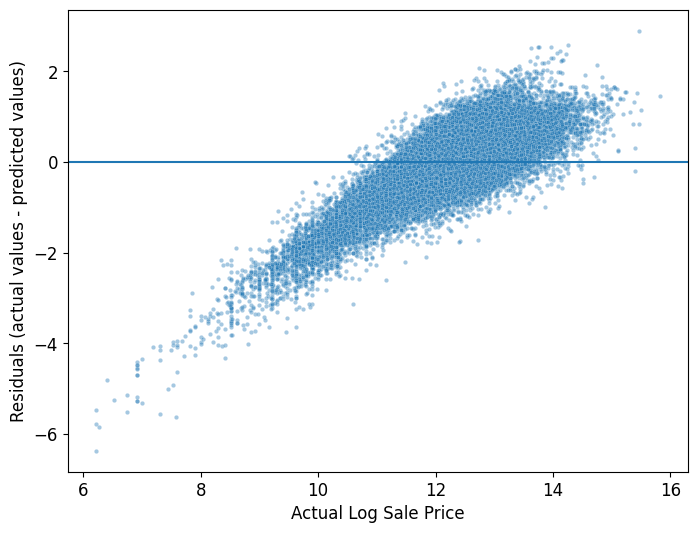

In [18]:
fig, ax = plt.subplots(figsize=(8,6))
resid_valid =  Y_valid_m2 - Y_predicted_m2
sns.scatterplot(
    x = Y_valid_m2,
    y = resid_valid,
    s = 10,
    alpha = 0.4
);
plt.axhline(y=0)
ax.set_xlabel('Actual Log Sale Price');
ax.set_ylabel('Residuals (actual values - predicted values)');

<!-- END QUESTION -->

<br>

--- 

## Question 4b

Based on the structure you see in your plot, does this model seem like it will correspond to _regressive_, _fair_, or _progressive_ taxation?

Assign "regressive", "fair" or "progressive" to `q4b` in the cell below accordingly.


In [19]:
#solution
q4b = "regressive"

While our simple model explains some of the variability in price, there is certainly still a lot of room for improvement —— one reason is we have been only utilizing 1 or 2 features (out of a total of 70+) so far! Can you engineer and incorporate more features to improve the model's fairness and accuracy? We won't be asking you to provide your answers here, but this will be important going into the next part of this project.

<br>

<hr style="border: 1px solid #fdb515;" />

# Question 5

It is time to build your own model!

You will conduct feature engineering on your training data using the `feature_engine_final` function (you will define this in `q5d`), fit the model with this training data, and compute the training Root Mean Squared Error (RMSE). 

In the end, we will load our test data with `feature_engine_final`, use the model to predict `Log Sale Price` for the test data, transform the predicted and original log values back into their original forms (by using `delog`), and compute the test RMSE.

Your goal in Question 5 is to:

* Define a function to perform feature engineering and produce a design matrix for modeling.
* Apply this feature engineering function to the training data and use it to train a model that can predict the `Log Sale Price` of houses.

Outline:
* In Question 5a, you can explore possible features for your model.
* In Question 5b, you can perform EDA on the dataset.
* In Question 5c, you can define feature engineering helper functions.
* In Question 5d, you will create your design matrix and train a model.
* In Question 5e, you can fit and evaluate your model.

<br><br>

---
## Some notes before you start

- **If you are running into memory issues, restart the kernel and only run the cells you need to.** If you want to delete specific variables, you may also use `del` in place of `%reset -f%`. For example, the following code will free up memory from data used for older models: `del training_val_data, test_data, train, validation, X_train_m1, X_valid_m1, X_train_m2, X_valid_m1`.
- **If you need the data again after deleting the variables or resetting, you must reload them again from earlier in the notebook.**

<br>

---

## Question 5a: Finding Potential Features

This question is intended to give helpful guidance on how to get started with feature engineering in `q5d`. You may write as little or as much as you would like here; it will not factor into your grade. Read the documentation about the dataset in `codebook.txt`, located in this directory. Is there any data you think may be related to housing prices? Include them below for future reference.

_Type your answer here, replacing this text._

<br>

---

## Question 5b: More EDA


This question is intended to give helpful guidance on how to get started with feature engineering. You may write as little or as much as you would like here; it will not factor into your grade. Use the scratch space below to conduct any additional EDA you would like to see. You may use this space to make additional plots to help you visualize the relationship between any variables or compute any relevant statistics. You are free to add any number of cells as needed below and before the next question. You may find it helpful to review part 1 and the techniques we explored there.


<details>
    <summary>[<b>Click to Expand</b>] Some potential ideas. </summary>
    
* Plot the distribution of a variable. Is this variable heavily skewed? Are there any outliers? This can inform how you engineer your features later on.

* Make a scatter plot between a continuous feature and the outcome. Is there a relationship? Is there a transformation that may linearize the relationship?

* Make a plot of a categorical/discrete feature and the outcome. Is there a relationship? How can we transform this categorical data into numerical features that can be useful for OLS?

* Find the correlation coefficient between features and the outcome. Is there a strong relationship between the two? Can you find the correlation coefficient between different transformations of the feature and the outcome?

</details>

In [ ]:
# Add any EDA code below

<br>

---

## Question 5c: Defining Helper Function or Helper Variables

Use this space below to define any additional helper functions you may use in your final model. These can be transformation functions you identified in the optional question above. 

In [ ]:
# Define any additional helper functions or variables you need here

<br>

---

## Question 5d: Defining The Pipeline Function

Just as in the guided model from the previous question, you should encapsulate as much of your workflow into functions as possible. Your job is to select better features and define your own feature engineering pipeline inside the function `feature_engine_final` in the following cell. Use of `.pipe` is not required, but you are welcome to incorporate it!

- Any feature engineering techniques that involve referencing `Sale Price` (for example, removing outlying `Sale Price` values from the training data) should be performed under the condition `if not is_test_set:`.
- All other feature engineering techniques should be applied to both the training and test sets. This means that you should perform them under the condition `else:`.
- When `is_test_set` is `True`, your function should return only the design matrix, `X`.
- When `is_test_set` is `False`, your function should return both the design matrix and the response variable `Y` (the `Log Sale Price` column).

**Hints:**
-  Some features may have missing values in the test set but not in the training/validation set. Make sure `feature_engine_final` handles missing values appropriately for each feature.
- You may wish to consider removing outlying datapoints from the training set before fitting your model. You may not, however, remove any datapoints from the test set (after all, the CCAO could not simply "refuse" to make predictions for a particular house!)
- As you finetune your model, you may unintentionally consume too much memory, causing your kernel to crash. See `q5a` for guidance on how to resolve this!!

In [ ]:
# Please include all of your feature engineering processes inside this function.
# Do not modify the parameters of this function.
def feature_engine_final(data, is_test_set=False):
    # Whenever you access 'Log Sale Price' or 'Sale Price', make sure to use the
    # condition is_test_set like this:
    if not is_test_set:
        # Processing for the training set (i.e. not the test set)
        # CAN involve references to sale price!
        # CAN involve filtering certain rows or removing outliers
        data['Log Sale Price'] = np.log(data['Sale Price'])
        ...
    else:
        # Processing for the test set
        # CANNOT involve references to sale price!
        # CANNOT involve removing any rows
        ...
        
    # Processing for both test and training set
    # CANNOT involve references to sale price!
    # CANNOT involve removing any rows
    ...
    
    
    # Return predictors (X) and response (Y) variables separately
    if is_test_set:
        # Predictors 
        X = ...
        return X
    else:
        # Predictors. Your X should not include Log Sale Price!
        X = ...
        # Response variable
        Y = ...
        
        return X, Y

<br>

---

## Question 5e: Fit and Evaluate your Model

As a quality measure we use the RMSE defined as follows:

$$RMSE = \sqrt{\dfrac{\sum_{\text{houses in the set}}(\text{actual price for house} - \text{predicted price for house})^2}{\text{number of houses}}}$$

A function that computes the RMSE is provided below.

In [ ]:
def rmse(predicted, actual):
    """
    Calculates RMSE from actual and predicted values.
    Input:
      predicted (1D array): Vector of predicted/fitted values
      actual (1D array): Vector of actual values
    Output:
      A float, the RMSE value.
    """
    return np.sqrt(np.mean((actual - predicted)**2))

<details>
    <summary>[<b>Click to Expand</b>] Hints: </summary>
    
Train set:

* Check your RMSE on the training data. Is this a reasonable number? Keep in mind that training error is generally less than testing error. 

Test set:
* Since test and training/validation sets come from the same population (recall that test and training/validation sets are a random split from larger data), we expect our test prediction to have a similar range as the validation data. Plot the observed training (Log) Sale Price and the predicted (Log) Sale Price. Are the ranges similar? Do you have any unreasonable extreme prediction that cannot be exponentiated?    
</details>

In [ ]:
# Use this space to evaluate your model
# if you reset your memory, you need to define the functions again

Congratulations on finishing your prediction model for home sale prices in Cook County!